In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

#
import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy


## Extraer usuarios

In [2]:
# get users and mentions from the download files:
tweets_datas_path = ['dwnld_debate.json',
                     'dwnld_1.json',
                     'dwnld_2.json',
                     'dwnld_3.json',
                     'dwnld_4.json',
                     'Raw_tweets_0.json',
                     'Raw_tweets_1.json',
                     'Raw_tweets_a.json'
                    ]                    
tw_id=[]
tw_user_id=[]
tw_user=[]
tw_text=[]
entities_long=[]
mentioned_ids=[]

for json_file in tweets_datas_path:
    with open(json_file, "r") as tweets_file:
        for line in tweets_file:
            try:
                tweet = json.loads(line)
                tw_entities=[]
                tw_id.append(tweet["id_str"])
                tw_user_id.append(tweet["user"]["id_str"])
                tw_user.append(tweet["user"]["screen_name"])
                tw_entities.extend(tweet["entities"]["user_mentions"])
                entities_long.extend(tweet["entities"]["user_mentions"])
                tw_text_loop=[tweet["text"]]
                if tweet["truncated"]:#=="True": # Truncated indica si el tweet es corto o largo; si truncado, busca extendido
                    tw_text_loop=[tweet["extended_tweet"]["full_text"]]
                    tw_entities.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                    entities_long.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                else:
                    if tweet["text"][0:2]=="RT":
                        if tweet["retweeted_status"]["truncated"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                        else: 
                            tw_text_loop=[tweet["retweeted_status"]["text"]]
                            tw_entities.extend(tweet["retweeted_status"]["entities"]["user_mentions"])
                        if tweet["retweeted_status"]["is_quote_status"]:
                            tw_entities.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                    else:
                        tw_text_loop=[tweet["text"]]
                mentioned_ids.append([tweet["id_str"],tweet["user"]["id_str"],list(set([ent["id_str"] for ent in tw_entities]))])
                tw_text.append([tweet["id_str"],tw_text_loop])
            except:
                continue



    


In [3]:
print("Tweets identificados con código     :",len(tw_id),"\n",
      "Tweets con usuario identificado     :",len(tw_user_id),"\n",
      "Tweets con nombre de usuario        :",len(tw_user),"\n",
      "Textos de tweets recuperados        :",len(tw_text),"\n",
      "Total de Menciones en los tweets    :",len(entities_long),"\n",
      "Tweets con menciones identificadas  :",len(mentioned_ids),"\n"
)

Tweets identificados con código     : 738461 
 Tweets con usuario identificado     : 738461 
 Tweets con nombre de usuario        : 738461 
 Textos de tweets recuperados        : 738083 
 Total de Menciones en los tweets    : 3557581 
 Tweets con menciones identificadas  : 738083 



In [4]:
tweets_ids=pd.DataFrame({"tw_id":tw_id,
              "tw_user_id":tw_user_id,
              "tw_user":tw_user
             })
ids_freqs=pd.crosstab(index=tweets_ids.tw_user, columns="count")
ids_freqs=ids_freqs.sort_values(by=['count'] , ascending=False)["count"]
print("twiteros:",ids_freqs.shape[0])

twiteros: 109769


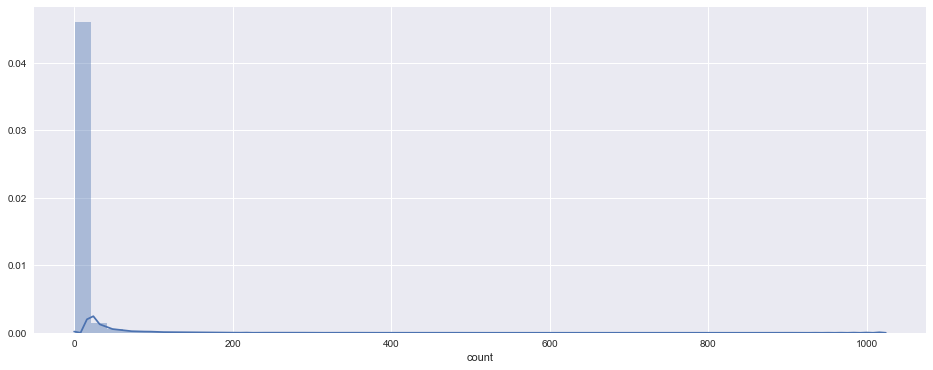

In [5]:
plt.figure(figsize=(16,6))
sns.distplot(ids_freqs)

In [6]:
round(ids_freqs.describe(),3)

count    109769.000
mean          6.727
std          21.991
min           1.000
25%           1.000
50%           2.000
75%           4.000
max        1023.000
Name: count, dtype: float64

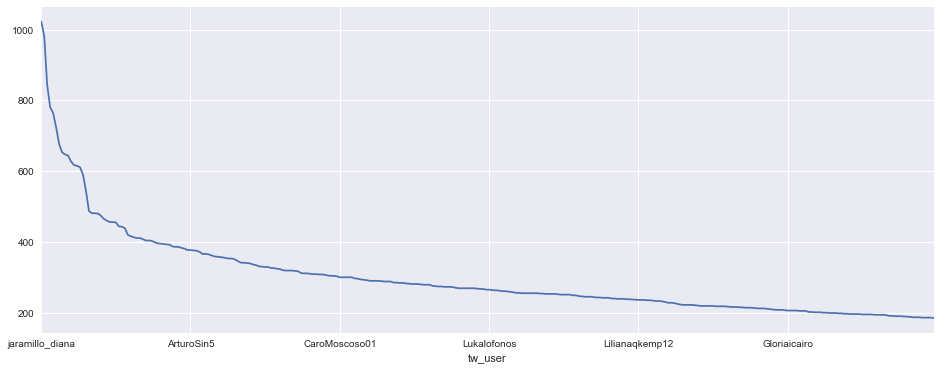

In [7]:
ids_freqs[:300].plot(figsize=(16, 6))

In [8]:
ids_freqs.sort_values(ascending=False)[:60]

tw_user
jaramillo_diana    1023
pierrealee          983
Cmarcafederal       844
NANACHAGU           781
TWITERM99417410     764
PORMIPATRIAYA       724
CarrillonavasG      677
abel3131            653
nenoriega5          647
AbCarrymar          644
AlexisSCol          627
SenorCaicedo        617
valderramaangel     615
GusDuque1           611
marco_caldon        590
MejorBogotaGVL      544
Yaniracolombia      487
cesar_garcia_nt     481
waltermunevar       481
juansex11151175     480
diegopfaff          474
biolucho2005        465
MejorCundinamar     460
macdonal5           456
Caldasllerista      456
Monyrica            455
VictoriaRubian5     444
lguzmangomez        443
GPATTYVT            439
ktina_mejia         420
josecastano0904     416
lugicas             413
Amparoc66           411
krlosgiraldo1       411
Gustavo68831299     408
dinirro             404
toxico2007          404
Kinopodia           403
DieGatto1           399
SGTBerkoff1981      396
jjolivella          395
anibalac

In [9]:
ids_freqs.to_csv("freqs_tweets.csv")

In [10]:
uniq_ids=list(set([entit["id_str"]for entit in entities_long]))
len(uniq_ids)

38398

In [11]:
ments_df=pd.DataFrame([[entit["id_str"],
                        entit["screen_name"],
                        entit["name"]
                       ]for entit in entities_long],
                     columns=["id_str","screen_name","name"])

In [12]:
ments_freq=pd.crosstab(index=ments_df.screen_name, columns="count")
ments_freq=ments_freq.sort_values(by=['count'] , ascending=False)
print("Cuentas mencionadas",ments_freq.shape[0])

Cuentas mencionadas 38490


### Clustering Candidatos

In [13]:
scr_nm_cands=["DeLaCalleHum", "ClaraLopezObre",
              "MoralesViviane",
              "sergio_fajardo","ClaudiaLopez",
              "VotoenblancoCo",
              "piedadcordoba","JaimeAraujoR",
              "prjorgetrujillo",
              "German_Vargas","PinzonBueno",
              "IvanDuque","mluciaramirez",
              "petrogustavo","angelamrobledo"
              ]

#[ments_df.loc[ments_df.screen_name==nm_cand].iloc[0:1,0] for nm_cand in scr_nm_cands]
id_str_cand=["823348278830002177","126832572",
             "86622012",
             "25185308","137908875",
             "910144193586188288",
             "34798360","2542586322",
             "232344683",
             "20456814","3401638840",
             "77653794","198984928",
             "49849732","165748292"
             ]

cands_mntns=np.array([[cand in tw_mntns[2] for cand in id_str_cand]for tw_mntns in mentioned_ids])
cands_mntns.shape


(738083, 15)

In [14]:
df_cands_mntns=pd.DataFrame(cands_mntns,columns=scr_nm_cands)

IvanDuque          326042
petrogustavo       309129
sergio_fajardo      66026
DeLaCalleHum        62325
German_Vargas       58223
mluciaramirez       34225
ClaudiaLopez        20134
angelamrobledo      20099
PinzonBueno         10514
piedadcordoba        3321
MoralesViviane       2789
ClaraLopezObre       2082
JaimeAraujoR           21
prjorgetrujillo         7
VotoenblancoCo          5
dtype: int64


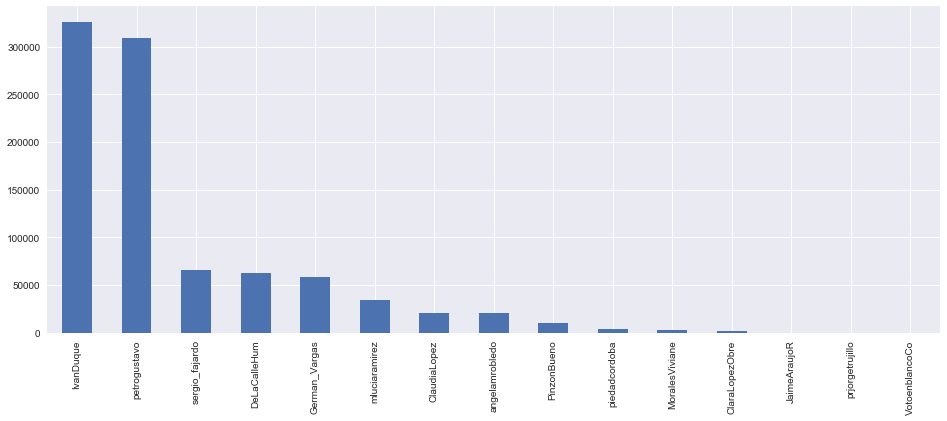

In [15]:
plt.figure(figsize=(16,6))
print (df_cands_mntns.sum(axis=0).sort_values(ascending=False))
df_cands_mntns.sum(axis=0).sort_values(ascending=False).plot(kind="bar")

In [16]:
# plt.figure(figsize=(15,12))
# plt.imshow(df_cands_mntns.iloc[:25,:], cmap=plt.cm.gray_r, interpolation='nearest')

In [17]:
cands_ward= hierarchy.linkage(df_cands_mntns.transpose(), 'ward')

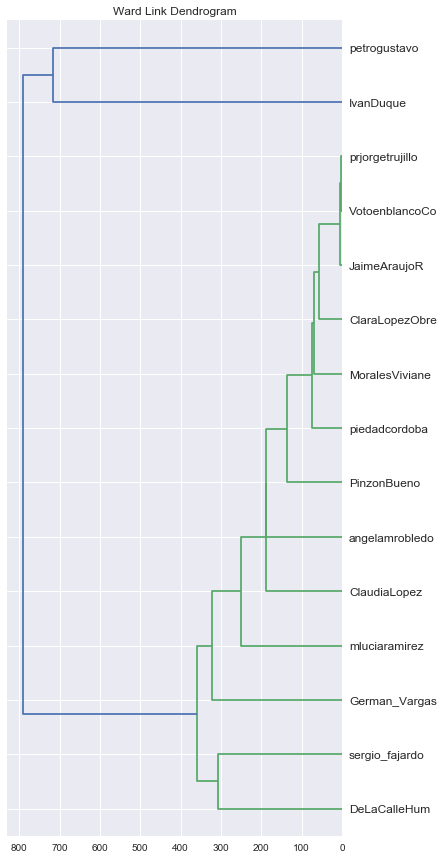

In [18]:
#max_d = 10
plt.figure(figsize=(6,15))
#plt.figure()
dn = hierarchy.dendrogram(cands_ward,orientation="left", labels=scr_nm_cands)
#plt.axhline(y=max_d, c='k')
plt.title('Ward Link Dendrogram')
#plt.savefig('dendrograma_ward_link.jpg')
plt.show()

### Clustering Nexos

In [19]:
id_ments=pd.crosstab(np.array([tw_mnt for tw_mntns in mentioned_ids for tw_mnt in tw_mntns[2] ]), columns="count").sort_values(ascending=False, by="count")

In [20]:
top_n=200

In [21]:
ments_ids_top=list(id_ments.index[:top_n])

In [22]:
mntns_top_ocurr=np.array([[cand in tw_mntns[2] for cand in ments_ids_top]for tw_mntns in mentioned_ids])

In [23]:
mntns_top_ocurr.shape

(738083, 200)

In [24]:
names_mnts_top=[]
for usr_id in id_ments.index[:top_n]:
    name=""
    try:
        name=ments_df[ments_df.id_str==usr_id].screen_name.iloc[0]
    except:
        name="Unknown"
#     print(usr_id, name)
    names_mnts_top.append(name)
        
#     print(usr_id,tweets_ids[tweets_ids.tw_user_id==usr_id].tw_user.iloc[0])

In [25]:
df_mntns_top_ocurr=pd.DataFrame(mntns_top_ocurr,columns=names_mnts_top)

IvanDuque          326042
petrogustavo       309129
sergio_fajardo      66026
DeLaCalleHum        62325
German_Vargas       58223
AlvaroUribeVel      46616
mluciaramirez       34225
CeDemocratico       30034
ClaudiaLopez        20134
angelamrobledo      20099
HOLLMANMORRIS       19451
OIZuluaga           18777
GustavoBolivar      13888
matadoreltiempo     12589
MejorVargasLle      12334
NoticiasCaracol     11441
ColombiaHumana_     11292
JuanManSantos       11272
PinzonBueno         10514
FiscaliaCol          9805
dtype: int64


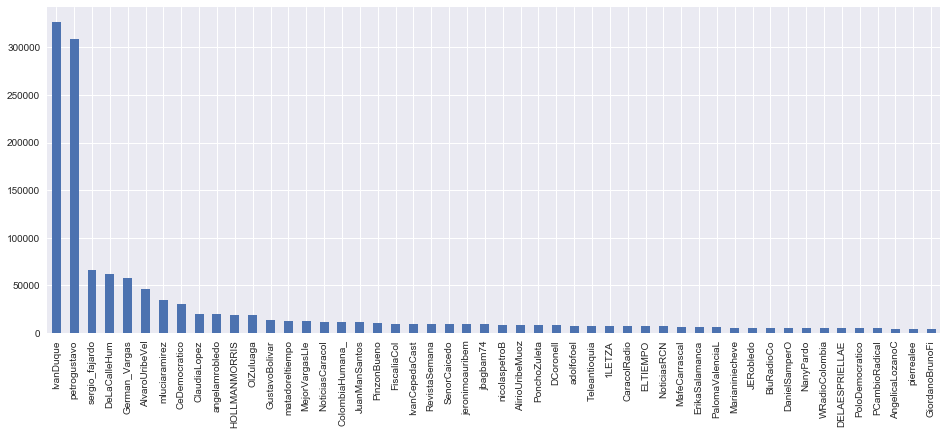

In [26]:
plt.figure(figsize=(16,6))
print (df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:20])
df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar")

In [27]:
mntns_ward= hierarchy.linkage(df_mntns_top_ocurr.transpose(), 'ward')

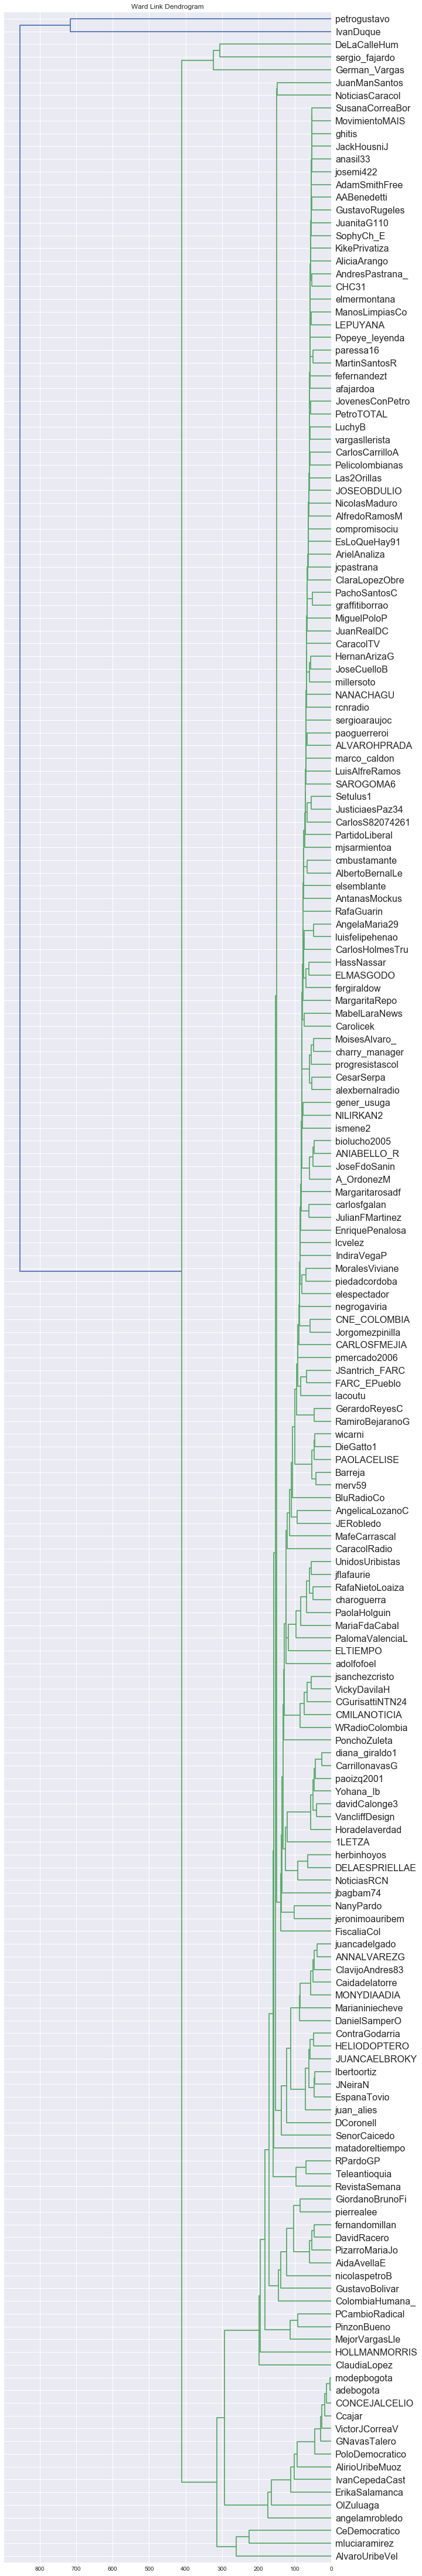

In [ ]:
#max_d = 10
plt.figure(figsize=(10,80))
#plt.figure()
dn = hierarchy.dendrogram(mntns_ward,orientation="left", labels=names_mnts_top)
#plt.axhline(y=max_d, c='k')
plt.title('Ward Link Dendrogram')
plt.yticks(fontsize=16)
# plt.savefig('dendrograma_ward_link_mentions.jpg')
plt.show()

## Clustering Tuiteros

In [ ]:
twtxt_ids=[txt_id[0] for txt_id in tw_text]
ids_mnts=pd.DataFrame(([np.array(tweets_ids.loc[tweets_ids.tw_id==twtx_id,["tw_user_id","tw_user"]])[0] for twtx_id in twtxt_ids]))
clmns=["tw_user_id","tw_user"]
clmns.extend(list(df_mntns_top_ocurr.columns))
mnts_top_df=pd.DataFrame(np.column_stack([np.array(ids_mnts),mntns_top_ocurr]),
                         index=twtxt_ids, columns=clmns)


In [ ]:
usr_freq_top_ments=mnts_top_df.iloc[:,1:].groupby('tw_user').sum()
usr_freq_top_ments.to_csv("tuiteros_menciones.csv")

In [ ]:
usr_freq_top_ments.loc[list(ids_freqs.index[:300]),:]

In [ ]:
usrs_ward= hierarchy.linkage(usr_freq_top_ments.loc[list(ids_freqs.index[:300]),:], 'ward')

In [ ]:
#max_d = 10
plt.figure(figsize=(10,100))
#plt.figure()
dn = hierarchy.dendrogram(usrs_ward,orientation="left", labels=list(ids_freqs.index[:300]))
#plt.axhline(y=max_d, c='k')
plt.title('Ward Link Dendrogram')
plt.yticks(fontsize=16)
# plt.savefig('dendrograma_ward_link_mentions.jpg')
plt.show()